In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import json
import os 

In [2]:
# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set model to evaluation mode

/home/boron/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/boron/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]   
    )
])

In [14]:
with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
idx2synset = [class_idx[str(k)][0] for k in range(len(class_idx))]
id2label = {v[0]: v[1] for v in class_idx.values()}

imagenet_path = './imagenet_samples'

# List of image file paths
image_paths = os.listdir(imagenet_path)

print("ImagePaths: ", image_paths)

ImagePaths:  ['mountain_bike.JPEG', 'mousetrap.JPEG', 'paintbrush.JPEG', 'peacock.JPEG', 'piggy_bank.JPEG']


In [15]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from functools import reduce

In [ ]:
# code modified from https://github.com/TimothyDelille/LIME/tree/master/LIME_for_Image_Classification

In [16]:
def to_img(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = 255.*(tensor.cpu().permute(1,2,0).numpy()*std.reshape(1,1,3)+ mean.reshape(1,1,3))
    return img.astype(np.uint8)

In [17]:
def turn_off_segments(image, segments, segment_ids, replace_value = 0.):
    segments_ext = segments.unsqueeze(0).repeat(3,1,1)
    dummy = torch.ones_like(image)
    condition = reduce(lambda a,b: (a)|(b), [segments_ext == dummy*id_ for id_ in segment_ids])
    return torch.where(condition, torch.tensor(replace_value), image)

In [18]:
def turn_segments_green(image, segments, segment_ids, alpha=0.5):
    segments_ext = segments.unsqueeze(0).repeat(3, 1, 1)
    dummy = torch.ones_like(image)
    condition = reduce(lambda a, b: a | b, [segments_ext == dummy * id_ for id_ in segment_ids])
    return torch.where(condition, torch.tensor(0.43), image)

In [19]:
def exp_kernel(x, z, distance, sigma):
    return torch.exp(-distance(x,z)**2 / sigma**2)

def L2_distance(x,z):
    return torch.dist(x,z,p=2)

In [20]:
from sklearn import linear_model

def train_local_model(x, N, K, segments):
    _, predicted_idx = predict(x.unsqueeze(0)).max(dim = 1)
    predicted_idx = predicted_idx.item()
    predicted_synset = idx2synset[predicted_idx]
    predicted_label = idx2label[predicted_idx]
    print(f"Predicted label: {predicted_synset} ({predicted_label})") 

    n_segments = len(torch.unique(segments))

    instances_g = [] # contains the z_prime
    instances_f = [] # contains the z
    kernel = [] # contains the weigths given by the kernel function

    for _ in range(N):
        #sample instances around x′ by drawing nonzero elements of x′ uniformly at random 
        #where the number of such draws is also uniformly sampled
        segment_ids = np.unique(np.random.choice(np.arange(n_segments) , size = n_segments)).tolist()
        z = turn_off_segments(x, segments, segment_ids) #input image with masked pixels
        z_prime = torch.ones(n_segments) # z_prime is the interpretable version: a tensor of ones with for each segment that is present
        z_prime[segment_ids] = 0.

        instances_g.append(z_prime.unsqueeze(0)) # shape (1, n_segments)
        instances_f.append(z.unsqueeze(0))
        kernel.append(exp_kernel(x, z, L2_distance, sigma = 0.75*n_segments)) # kernel width used in the original implementation

    instances_g = torch.cat(instances_g, dim = 0) # shape (N, n_segments) N acts as a batch_size
    instances_f = torch.cat(instances_f, dim = 0)
    weights = torch.sqrt(torch.tensor(kernel)).unsqueeze(1)

    f = predict(instances_f) #(N, 1000)
    f = f[:, predicted_idx]

    y = (weights*f).cpu().numpy()
    X = (weights*instances_g).cpu().numpy()

    lars = linear_model.Lars(n_nonzero_coefs = K, fit_intercept = True)
    lars.fit(X,y)

    indices = np.where(lars.coef_ != 0.)[0].tolist()
    new_X = X[:, indices]
    lin_model = linear_model.LinearRegression().fit(new_X, y)

    R2 = lin_model.score(new_X,y)
    adj_R2 = 1 - (1-R2)*(N-1)/(N-K-1)
    print('Adjusted R squared: {:.2f}'.format(adj_R2))

    return indices, lin_model.coef_

In [21]:
from skimage.filters import gaussian

def explain_prediction(indices, input_tensor, segments):
    n_segments = len(torch.unique(segments))
    discard = [i for i in range(n_segments) if i not in indices]
    overlay = turn_off_segments(input_tensor, segments, discard)
    #overlay = 225.0 * gaussian(to_img(overlay), 1.5) # blur the edges to get a prettier result
    overlay = to_img(overlay)
    overlay = overlay.astype(np.uint8)

    #green_overlay = np.zeros_like(overlay)
    #green_overlay[...,0:3]=[0,255,0] 
    #green_overlay = Image.fromarray(green_overlay)
    #orig_im = Image.fromarray(to_img(input_tensor).astype(np.uint8))
    #enhanced_features = Image.blend(green_overlay, orig_im, 0.55)
    overlay = Image.fromarray(overlay)
    orig_im = Image.fromarray(to_img(input_tensor))
    enhanced_features = Image.blend(overlay, orig_im, 0.5)
    display(enhanced_features)

In [24]:
def predict(input_batch):
    input_batch = input_batch.to(device)
    model.eval()
    model.to(device)
    with torch.no_grad():
        output = model(input_batch)

    return output

SLIC number of segments: 192


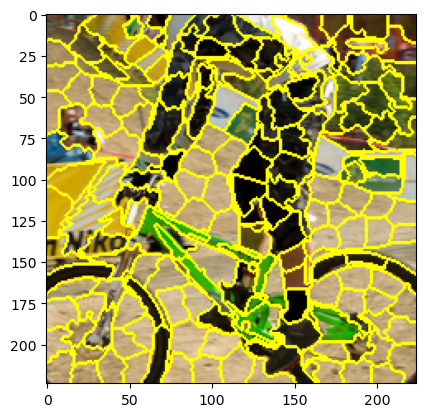

Predicted label: n03792782 (mountain_bike)
Adjusted R squared: 1.00


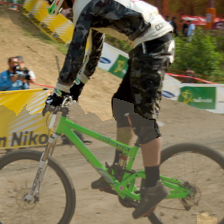

SLIC number of segments: 216


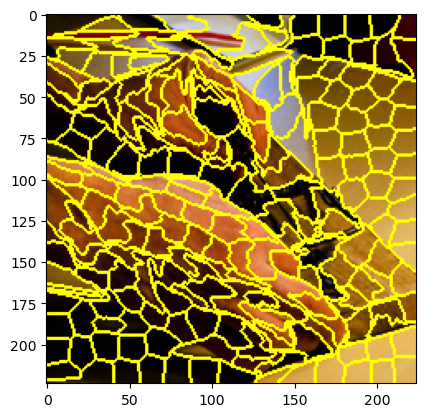

Predicted label: n03250847 (drumstick)
Adjusted R squared: 1.00


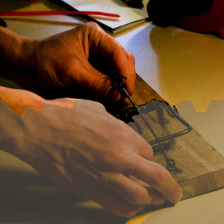

SLIC number of segments: 222


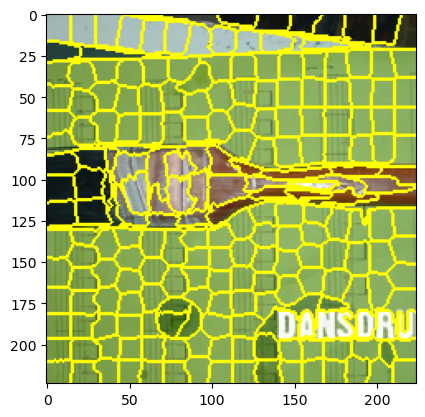

Predicted label: n04118776 (rule)
Adjusted R squared: 1.00


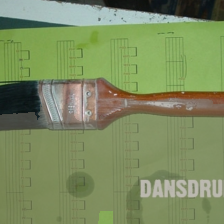

SLIC number of segments: 210


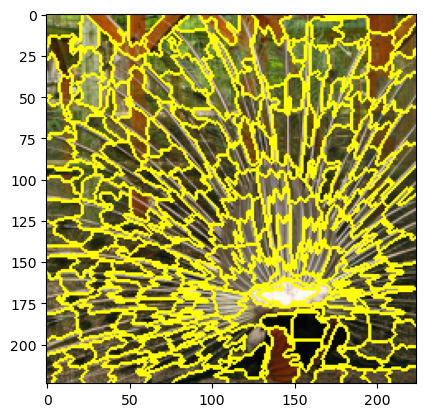

Predicted label: n01806143 (peacock)
Adjusted R squared: 1.00


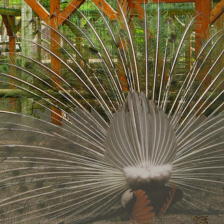

SLIC number of segments: 217


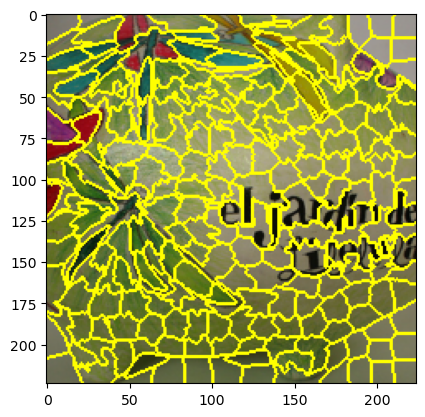

Predicted label: n03938244 (pillow)
Adjusted R squared: 1.00


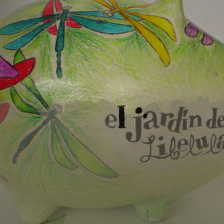

In [23]:
for img_path in image_paths:
    # Open and preprocess the image
    my_img = os.path.join(imagenet_path, img_path)
    input_image = Image.open(my_img).convert('RGB')
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

    img = to_img(input_tensor)
    segments_slic = slic(img, n_segments=250, compactness=10, sigma=1)
    print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
    plt.figure()
    plt.imshow(mark_boundaries(img, segments_slic))
    plt.show()
    
    segments = np.copy(segments_slic)
    segments = torch.tensor(segments)
    
    indices, coefs = train_local_model(input_tensor, N = 100, K = 10, segments = segments)

    explain_prediction(indices, input_tensor, segments)
